# 1. Bell-Wigner inequality

<center><img src="../../figures/qibo_mascotte/qibo_bell_wigner.png" alt="drawing" width="400"/></center>
<center>Qibo, Bell and Wigner discussing about inequalities at CERN [DALL-E].</center>

### Introduction

_This notebook is an integral part of the paper [Simulating Bell inequalities with Qibo](https://arxiv.org/abs/2501.01434), where the popular inequalities concerning quantum Bell states are presented for educational purposes._

In the first of this series, we instantiate a quantum circuit with Qibo in order to study the violation of the inequality proposed by Wigner in 1970 to illustrate Bell's findings, which we name Bell-Wigner inequality (cf. paper).

Let us define the quantity $Q^W$ as:

$$Q^W = P(\hat{a}+,\hat{b}+) - P(\hat{a}+,\hat{c}+) - P(\hat{c}+,\hat{b}+),$$

where, as an example, with $P(\hat{a}+,\hat{b}+)$ we mean the probability of measuring both particles in the state $|1\rangle$.

In the case of local hidden (LH) variables, the inequality reads:

$$Q^W_{LH} \le 0$$

We will show how to prepare a quantum state where the $Q^W$ quantity violates the assumptions of locality as discussed in the paper.

In the [next notebook](./Bell64.ipynb), we turn to the original Bell inequality.

### Setup

Let's start by importing the necessary Python packages. You can install Qibo by executing `pip install qibo` in your environment, see [Qibo Quick start](https://qibo.science/qibo/stable/getting-started/quickstart.html) for further details.

In [1]:
import time
from math import pi

import matplotlib.pyplot as plt

import qibo
from qibo import Circuit, gates

# plotting function
from qiboedu.scripts.plotscripts import plot_bell_inequalities

qibo.set_backend(backend="numpy")

[Qibo 0.2.13|INFO|2024-11-13 14:25:38]: Using numpy backend on /CPU:0


Here we instantiate a circuit with free parameters $\phi$ and $\theta$ for the rotations before the measurement. The initial $X$ gates convert a $|0\rangle$ initial state to $|1\rangle$ prior to constructing the Bell state.

In [2]:
c = Circuit(2)
c.add(gates.X(q=0))
c.add(gates.X(q=1))
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.RZ(q=0, theta=0))
c.add(gates.RZ(q=1, theta=0))
c.add(gates.RY(q=0, theta=0))
c.add(gates.RY(q=1, theta=0))
c.add(gates.M(0, 1))
c.draw()

q0: ─X─H─o─RZ─RY─M─
q1: ─X───X─RZ─RY─M─


Now we define a function to run the simulation for some given values of $\phi_0$, $\phi_1$, $\theta_0$, and $\theta_1$. The return value is the probability of the `00` outcome, as this is the only relevant value in order to compute the $Q^W$ quantity.

We also define a number of parameters for the simulation.

In [3]:
def run_circuit_00(phi_0, phi_1, th_0, th_1):
    '''
    Run the simulation for the given choice of ``phi_0``, ``phi_1``, ``theta_0``, ``theta_1``,
    and return the probability of the "00" outcome
    '''
    c.set_parameters([phi_0, phi_1, th_0, th_1])
    return c(nshots=nshots).frequencies()['00'] / nshots

# parameters for the simulation
ab_steps = 4
phi_steps = 4
ac_steps = 100
nshots = 10000

Now let's run the simulation, and note the computation time. Different Qibo and hardware (e.g. GPU vs CPU) backends may yield significantly different timings.

In [4]:
Q_W = {}
tstart = time.time()   # keep track of the timing: this is not accurate for proper benchmarking, but it's good enough in this context

for i_ab in range(ab_steps+1):
    print('Run for theta_ab = %dpi/%d...' % (i_ab, ab_steps))

    th_ab = pi * i_ab/ab_steps    # theta_ab angles go from 0 to pi inclusive
    P_ab = run_circuit_00(0, 0, 0, th_ab)
    
    Q_W[i_ab] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        P_ac = run_circuit_00(0, 0, 0, th_ac)
        P_cb = run_circuit_00(0, 0, th_ac, th_ab)
        Q_W[i_ab].append(P_ab - P_ac - P_cb)

print('Completed in %.1f seconds' % (time.time() - tstart))

Run for theta_ab = 0pi/4...
Run for theta_ab = 1pi/4...
Run for theta_ab = 2pi/4...
Run for theta_ab = 3pi/4...
Run for theta_ab = 4pi/4...
Completed in 1.1 seconds


## Plots

Here we plot the obtained values of $Q^W$ using a dedicated plotscript which can be found in `qiboedu.scripts.plotscripts`.

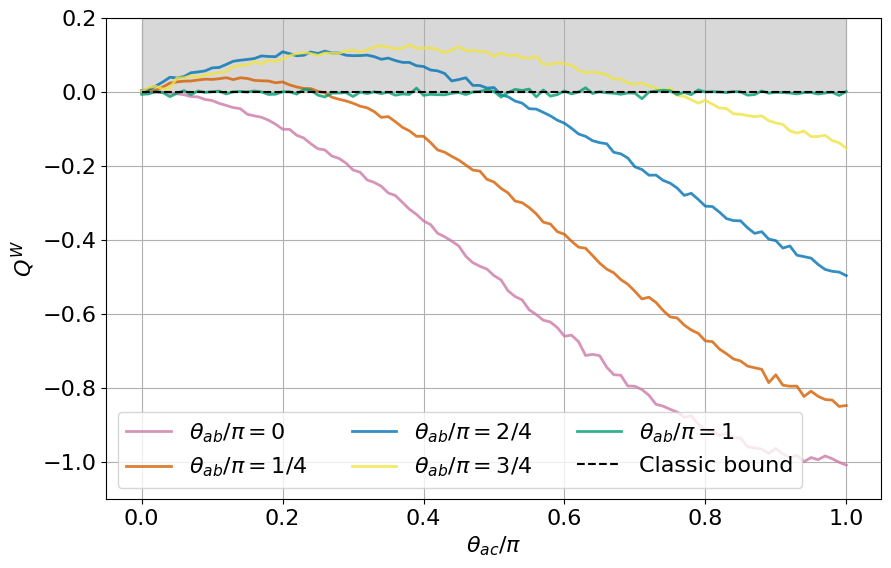

In [5]:
plot_bell_inequalities(
    experiment='bell-wigner', 
    Q_values=Q_W, 
    ac_steps=ac_steps, 
    param_steps=ab_steps, 
    param_label='\\theta_{ab}', 
    y_bounds=(-1.1, 0.2),
    img_width=1, 
    legendloc=3
)

As an additional exercise, we generate a radial plot: this plot better illustrates the evolution of $Q^W$ when changing $\theta_{ac}$ from 0, which corresponds to $\hat{c}$ aligned with the $z$ axis, conventionally represented as the North direction, to $\pi$, which corresponds to $\hat{c}$ pointing to the South direction.

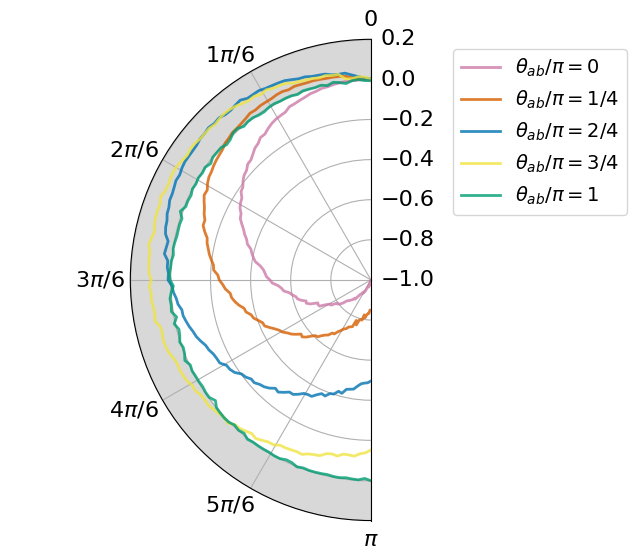

In [6]:
plot_bell_inequalities(
    experiment='bell-wigner', 
    Q_values=Q_W, 
    ac_steps=ac_steps, 
    param_steps=ab_steps, 
    param_label='\\theta_{ab}', 
    y_bounds=(-1, 0.2),
    img_width=1, 
    legendloc=3, 
    plot_projection='polar', 
)

---

## Rotation around the _z_ axis

This is an alternate simulation, where we rotate around the $z$ axis by the angle $\phi$ and then around the $y$ axis by a fixed angle $\theta_{ab}$. The simulation runs over different values of $\phi$.

In [7]:
Qz_W = {}
tstart = time.time()

th_ab = pi/2
P_ab = run_circuit_00(0, 0, 0, th_ab)
for i_phi in range(phi_steps+1):
    print('Run for phi = %dpi/%d...' % (i_phi, phi_steps))

    phi = pi * i_phi/phi_steps    # phi angles go from 0 to pi inclusive
    Qz_W[i_phi] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        P_ac = run_circuit_00(0, phi, 0, th_ac)
        P_cb = run_circuit_00(phi, 0, th_ac, th_ab)
        Qz_W[i_phi].append(P_ab - P_ac - P_cb)

print('Completed in %.1f seconds' % (time.time() - tstart))

Run for phi = 0pi/4...
Run for phi = 1pi/4...
Run for phi = 2pi/4...
Run for phi = 3pi/4...
Run for phi = 4pi/4...
Completed in 0.9 seconds


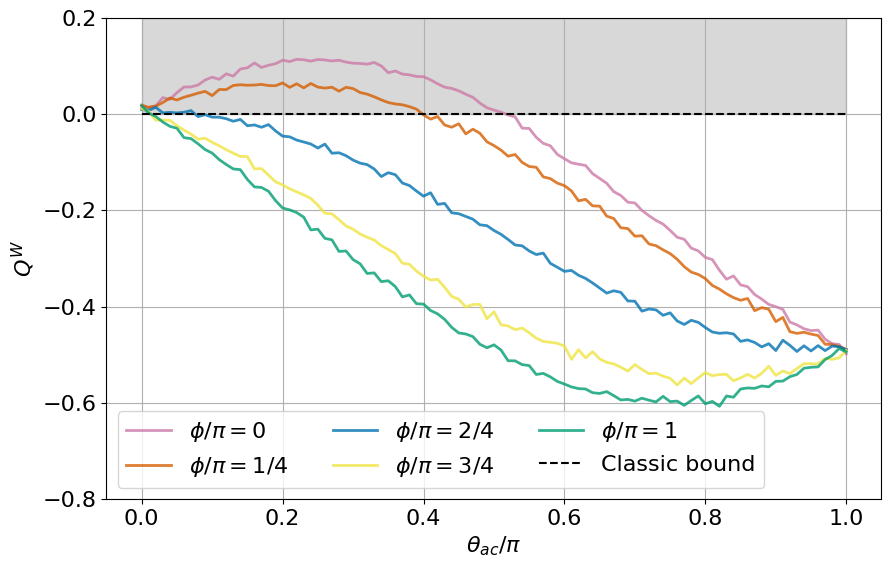

In [8]:
plot_bell_inequalities(
    experiment='bell-wigner', 
    Q_values=Qz_W, 
    ac_steps=ac_steps, 
    param_steps=phi_steps, 
    param_label='\phi', 
    y_bounds=(-0.8, 0.2),
    img_width=1, 
    legendloc=3
)